# Risk Analysis

# Goal:

One primary source of risk for DealShield is that more guaranteed vehicles will be returned than anticipated. 

In this case study, DealShield is experiencing a higher than expected return rate, and losses are rising quickly. 

The goal is to be able to score the risks of buyers, dealers, and vehicles in the dataset (even those which have no DealShield purchase history) so that 

1. a buyer whose "risky buyer score" is too high can be prohibited from purchasing DealShield guarantees in the future.
2. a dealer whose "risky dealer score" is too high can be checked when selling DealShield guarantees in the future.
3. a vehicle with a high "risky vehicle score" can be prohibited from having DealShield guarantees in the future.

Tasks

You are asked to create a "risky dealer score" that will indicate which dealers are more likely to result in an excessive number of returned vehicles based upon the characteristics of dealers, the characteristics of buyers, and the characteristics of sold vehicles. A return rate above 10% is considered excessive. 


1. develop the requested "risky dealer score" and validate its performance? 
2. identify and explain the characteristics of the dealers and the behaviors that indicate the dealer is of greater risk?

# Data


The Risky Dealer Case Study Transactions file contains records of wholesale vehicle sales. Each record gives specific details of the sales transaction. 

Note that only some of these transactions have DealShield guarantees applied to them, and of those, some result in returned vehicles and others do not. 

Descriptions of each field contained in the file are given below. Also note that the data is not intended to be perfect. That is, as usual, data that you have to use in your analysis is often "dirty" and may contain occassional erroneous or missing values. You must treat these accordingly and provide reasoning behind any action you may take to handle such data. 

In [1]:
import pandas as pd
import numpy as np

# Data Structure

In [2]:
df = pd.read_csv('data/Risky Dealer Case Study/Risky Dealer Case Study Transactions.csv')
df.head()

,BuyerID,SellerID,Mileage,VIN,SellingLocation,CarMake,SalePrice,CarYear,MMR,JDPowersCat,...,Salvage,OVE,Simulcast,InLane,PSIEligible,SaleDate,Autocheck_score,ConditionReport,DSEligible,Returned
0,351757,441081,37055,1FAHP3M27CL374352,CAAI,FORD,13000,2012,13050,COMPACT CAR,...,0,0,0,0,1,13-07-25,1.000000,NaN,1,0.0
1,351757,442235,248,1G1JE6SB7D4103706,DETA,CHEVROLET,13900,2013,13600,COMPACT CAR,...,0,0,0,0,1,13-10-24,NaN,NaN,1,NaN
2,351757,436280,39627,1G1PG5SC4C7102274,CAAI,CHEVROLET,13800,2012,14050,MIDSIZE CAR,...,0,0,0,1,1,13-04-18,-2.666667,41,1,NaN
3,351757,436280,50773,1G1PG5SC5C7113820,CAAI,CHEVROLET,12900,2012,13150,MIDSIZE CAR,...,0,0,0,1,1,13-04-18,1.000000,31,1,NaN
4,351757,434202,54133,1GNKVGED4BJ301146,SVAA,CHEVROLET,17800,2011,18050,SUV,...,0,0,0,1,1,13-02-26,-1.400000,34,1,NaN


In [3]:
for d in df.columns:
    print(d)

BuyerID
SellerID
Mileage
VIN
SellingLocation
CarMake
SalePrice
CarYear
MMR
JDPowersCat
LIGHTG
LIGHTY
LIGHTR
PSI
Arbitrated
Salvage
OVE
Simulcast
InLane
PSIEligible
SaleDate
Autocheck_score
ConditionReport
DSEligible
Returned


# Preprocessing
1. convert categorical attributes: 'SellingLocation', 'CarMake','JDPowersCat','CarYear','LIGHTG', 'LIGHTY', \
       'LIGHTR', 'Arbitrated', 'Salvage', 'OVE', 'Simulcast', 'InLane',
       'PSIEligible'
2. selected features: 'Mileage', 'SalePrice', 'MMR', 'PSI', 'SellingLocation', 'CarMake','JDPowersCat','CarYear','LIGHTG', 'LIGHTY', \
       'LIGHTR', 'Arbitrated', 'Salvage', 'OVE', 'Simulcast', 'InLane',
       'PSIEligible'
3. output feature: 'Returned'
4. ignored features: 
    
    4.1 Missing values: Autocheck_score	ConditionReport
        
    4.2 Uncertain features: DSEligible
        
    4.3 unrelated features: 'BuyerID', 'SellerID', 'CarYear', 'SaleDate'

In [4]:
from sklearn import preprocessing
def convert_categorical(data_df):
    label_encoder = preprocessing.LabelEncoder()
    for c in ['SellingLocation', 'CarMake','JDPowersCat','CarYear','LIGHTG', 'LIGHTY', \
           'LIGHTR', 'Arbitrated', 'Salvage', 'OVE', 'Simulcast', 'InLane',
           'PSIEligible']:
        data_df[c+'_label']= label_encoder.fit_transform(data_df[c])
    #oh_encoder = preprocessing.OneHotEncoder()
    oh_encoder = preprocessing.OneHotEncoder(categories='auto') 
    np_labels = oh_encoder.fit_transform(data_df[['SellingLocation_label', 'CarMake_label','JDPowersCat_label',\
                            'CarYear_label','LIGHTG_label', 'LIGHTY_label', 'LIGHTR_label', 'Arbitrated_label',  \
                           'Salvage_label', 'OVE_label', 'Simulcast_label', 'InLane_label', \
                           'PSIEligible_label']]).toarray()
    data_df = pd.concat([data_df, pd.DataFrame(np_labels)],axis=1)
    return data_df


In [5]:
# df_clean = pd.concat([df_clean, pd.DataFrame(np_labels)])
# df_clean.shape

In [6]:
df_clean = convert_categorical(df)
df_clean.shape

(278337, 371)

In [7]:
df_clean.columns

Index([        'BuyerID',        'SellerID',         'Mileage',
                   'VIN', 'SellingLocation',         'CarMake',
             'SalePrice',         'CarYear',             'MMR',
           'JDPowersCat',
       ...
                     323,               324,               325,
                     326,               327,               328,
                     329,               330,               331,
                     332],
      dtype='object', length=371)

In [8]:
output_feature="Returned"

input_features=['Mileage', 'SalePrice', 'MMR', 'PSI'] #, 'Autocheck_score'] #'ConditionReport',]

names = {}
for i in range(332):
    input_features.append(str(i))
    names[i] = str(i)
df_clean = df_clean.rename(columns=names)

In [9]:
df_clean.shape

(278337, 371)

Note that green, yellow, and red lights should not appear in combination. If this occurs it is a data error. In this case default to the highest warning when multiple lights exist.

In [10]:
df_clean['check-GYR'] = df_clean[['LIGHTG','LIGHTY','LIGHTR']].apply(lambda s:False if s[0]==s[1]==1 or s[0]==s[2]==1 or s[1]==s[2]==1 else True, axis=1)
df_clean = df_clean[df_clean['check-GYR']].drop('check-GYR',axis=1)
df_clean.shape

(262678, 371)

Statistics and correlation of the data show that all the attribures are independent.


In [11]:
df_selected = df_clean.dropna(subset=['Returned','JDPowersCat'])[input_features+[output_feature]]
df_selected = df_selected.fillna(value=0)
df_selected.shape

(18894, 337)

In [12]:
df_selected[input_features].dropna().describe()

,Mileage,SalePrice,MMR,PSI,0,1,2,3,4,5,...,322,323,324,325,326,327,328,329,330,331
count,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.0,18894.0,18894.000000,...,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000
mean,84849.706203,11374.059013,10865.581666,0.200699,0.001217,0.000370,0.000423,0.0,0.0,0.004816,...,0.212501,0.963639,0.036361,0.988515,0.011485,0.950249,0.049751,0.775749,0.224251,0.344977
std,46164.647381,7587.682777,7574.858363,0.400534,0.034870,0.019245,0.020573,0.0,0.0,0.069234,...,0.409088,0.187191,0.187191,0.106554,0.106554,0.217436,0.217436,0.417099,0.417099,0.475373
min,1.000000,250.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45976.000000,6100.000000,5425.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,83286.000000,10000.000000,9625.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,114668.750000,15000.000000,14700.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,363570.000000,163000.000000,81000.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
df_selected[input_features].corr()

,Mileage,SalePrice,MMR,PSI,0,1,2,3,4,5,...,322,323,324,325,326,327,328,329,330,331
Mileage,1.000000,-0.610216,-0.583052,-0.091615,-0.015710,-0.001760,-0.012881,NaN,NaN,0.047110,...,0.136032,-0.121314,0.121314,0.067782,-0.067782,0.058650,-0.058650,0.026392,-0.026392,0.645216
SalePrice,-0.610216,1.000000,0.894166,0.054141,0.009422,-0.014759,0.006987,NaN,NaN,-0.028105,...,-0.074338,0.078472,-0.078472,-0.118386,0.118386,-0.040469,0.040469,-0.002810,0.002810,-0.382298
MMR,-0.583052,0.894166,1.000000,0.040743,0.001311,-0.012974,0.006937,NaN,NaN,-0.026147,...,-0.065054,0.071749,-0.071749,-0.071431,0.071431,-0.042519,0.042519,0.002145,-0.002145,-0.363597
PSI,-0.091615,0.054141,0.040743,1.000000,0.020404,0.017820,0.008957,NaN,NaN,0.070119,...,-0.092324,0.070510,-0.070510,-0.072487,0.072487,-0.055514,0.055514,-0.065469,0.065469,-0.256625
0,-0.015710,0.009422,0.001311,0.020404,1.000000,-0.000672,-0.000719,NaN,NaN,-0.002429,...,-0.003293,0.006781,-0.006781,0.003763,-0.003763,-0.068803,0.068803,0.011492,-0.011492,-0.012563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,0.058650,-0.040469,-0.042519,-0.055514,-0.068803,-0.020893,-0.030787,NaN,NaN,-0.026274,...,0.027224,0.063487,-0.063487,-0.024664,0.024664,1.000000,-1.000000,-0.123024,0.123024,0.040596
328,-0.058650,0.040469,0.042519,0.055514,0.068803,0.020893,0.030787,NaN,NaN,0.026274,...,-0.027224,-0.063487,0.063487,0.024664,-0.024664,-1.000000,1.000000,0.123024,-0.123024,-0.040596
329,0.026392,-0.002810,0.002145,-0.065469,0.011492,0.010351,0.011066,NaN,NaN,-0.010252,...,0.064015,0.080631,-0.080631,-0.057954,0.057954,-0.123024,0.123024,1.000000,-1.000000,0.012458
330,-0.026392,0.002810,-0.002145,0.065469,-0.011492,-0.010351,-0.011066,NaN,NaN,0.010252,...,-0.064015,-0.080631,0.080631,0.057954,-0.057954,0.123024,-0.123024,-1.000000,1.000000,-0.012458


In [14]:
df_selected.head()

,Mileage,SalePrice,MMR,PSI,0,1,2,3,4,5,...,323,324,325,326,327,328,329,330,331,Returned
0,37055,13000,13050,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
11,38671,11000,12650,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
17,25010,14700,14750,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
27,40589,11700,12400,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
28,36386,13600,14400,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [15]:

df_positive = df_selected[df_selected['Returned']==0].copy()
df_negative = df_selected[df_selected['Returned']==1].copy()

In [16]:
df_positive.shape, df_negative.shape

((14917, 337), (3977, 337))

In [17]:
df_positive.columns

Index(['Mileage', 'SalePrice', 'MMR', 'PSI', '0', '1', '2', '3', '4', '5',
       ...
       '323', '324', '325', '326', '327', '328', '329', '330', '331',
       'Returned'],
      dtype='object', length=337)

# Sample Selection
Select 2000 records with Returned=0 as positive samples
Select 2000 records with Returned=1 as negative samples

In [18]:
train_df = pd.concat([df_positive[:2000],df_negative[:2000]])
test_df = pd.concat([df_positive[2000:4000],df_negative[2000:]])

In [19]:
train_df[input_features].dropna().shape, test_df[input_features].dropna().shape

((4000, 336), (3977, 336))

In [20]:
train_df.head()

,Mileage,SalePrice,MMR,PSI,0,1,2,3,4,5,...,323,324,325,326,327,328,329,330,331,Returned
0,37055,13000,13050,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
17,25010,14700,14750,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
27,40589,11700,12400,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
28,36386,13600,14400,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
29,70294,14200,14550,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [21]:
test_df.head()

,Mileage,SalePrice,MMR,PSI,0,1,2,3,4,5,...,323,324,325,326,327,328,329,330,331,Returned
43182,37791,25800,25800,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
43186,68249,10300,9850,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
43188,56620,10800,9675,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
43193,92443,4700,4900,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
43206,68623,9400,8025,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# Model Training
1. selected machine learning models: 'Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'Deep Learning'
2. The best model: 'XGBoost'

In [22]:

def scaleData(train,test,features):
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(train[features])
    train[features]=scaler.transform(train[features])
    test[features]=scaler.transform(test[features])
    
    return (train,test)


In [23]:
fitted_models_and_predictions_dictionary={}

In [24]:
def performance_assessment(predictions_df, output_feature='Returned', 
                           prediction_feature='predictions'):
    
    AUC_ROC = metrics.roc_auc_score(predictions_df[output_feature], predictions_df[prediction_feature])
    AP = metrics.average_precision_score(predictions_df[output_feature], predictions_df[prediction_feature])
    
    performances = pd.DataFrame([[AUC_ROC, AP]], 
                           columns=['AUC ROC','Average precision'])

    performances = performances.round(3)
    
    return performances



def performance_assessment_model_collection(fitted_models_and_predictions_dictionary, 
                                            transactions_df, 
                                            type_set='test'):

    performances=[]
    
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    
        predictions_df=transactions_df
            
        predictions_df['predictions']=model_and_predictions['predictions_'+type_set]
        
        performances_model=performance_assessment(predictions_df, output_feature=output_feature, \
                                                   prediction_feature='predictions')
        performances_model.index=[classifier_name]
        
        #performances=performances.append(performances_model)
        performances.append(performances_model)
    return pd.concat(performances) 

In [25]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical as one_hot

2023-12-21 18:26:31.740427: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:

N_CLASSES = 2

hidden_size = 293

class DeepLearningModel(tf.keras.Model):
    def __init__(self):
        super(DeepLearningModel, self).__init__()
        self.hidden_size = hidden_size
        self.hidden_layer1 = keras.layers.Dense(
            self.hidden_size,
            activation='relu',
            kernel_initializer=keras.initializers.TruncatedNormal(mean=0., stddev=1.)
        )
        self.hidden_size = self.hidden_size//2
        self.hidden_layer2 = keras.layers.Dense(
            self.hidden_size,
            activation='relu',
            kernel_initializer=keras.initializers.TruncatedNormal(mean=0., stddev=1.)
        )
        
        self.hidden_size = self.hidden_size//2
        self.hidden_layer3 = keras.layers.Dense(
            self.hidden_size,
            activation='relu',
            kernel_initializer=keras.initializers.TruncatedNormal(mean=0., stddev=1.)
        )
        self.prediction_layer = keras.layers.Dense(
            2,
            activation='softmax',
            kernel_initializer=keras.initializers.TruncatedNormal(mean=0., stddev=1.)
        )
        
        
        self.model = keras.Sequential()
        self.model.add(self.hidden_layer1)
        self.model.add(self.hidden_layer2)
        self.model.add(self.hidden_layer3)
        
    def call(self, inputs):
        
        latent = self.model(inputs)
        return self.prediction_layer(latent)


model = DeepLearningModel()
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.001),
              metrics=['accuracy'])
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                              verbose=1, min_delta=.01)

history = model.fit(train_df[input_features], one_hot(train_df[output_feature]),
                    epochs=100,
                    batch_size=30,
                    validation_data=(test_df[input_features],one_hot(test_df[output_feature])),
                   callbacks = [earlystopping])

Epoch 1/100
134/134 [==============================] - 2s 8ms/step - loss: nan - accuracy: 0.4990 - val_loss: nan - val_accuracy: 0.5029
Epoch 2/100
134/134 [==============================] - 1s 5ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5029
Epoch 3/100
134/134 [==============================] - 1s 5ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5029
Epoch 4/100
134/134 [==============================] - 1s 5ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5029
Epoch 5/100
134/134 [==============================] - 1s 5ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5029
Epoch 5: early stopping


In [27]:

predictions_test=model.predict(test_df[input_features])
predictions_test = [np.argmax(i) for i in predictions_test]

predictions_train=model.predict(train_df[input_features])
predictions_train = [np.argmax(i) for i in predictions_test]


model_and_predictions_dictionary = {'classifier': 'Deep Learning',
                                    'predictions_test': predictions_test,
                                    'predictions_train': predictions_train
                                   }

fitted_models_and_predictions_dictionary['Deep Learning'] = model_and_predictions_dictionary

125/125 [==============================] - 0s 2ms/step


In [28]:
import sklearn
from sklearn import *

import math
import sys
import time
#import graphviz
import xgboost

# For imbalanced learning
#import imblearn

import warnings
warnings.filterwarnings('ignore')


IR=1.0/4.0
IR=1.0/1.0

class_weight={0:IR,1:1.0}

classifiers_dictionary={'Logistic regression':sklearn.linear_model.LogisticRegression(random_state=0), 
                        'Decision tree with depth of two': sklearn.tree.DecisionTreeClassifier(max_depth=5,class_weight=class_weight,random_state=0),#sklearn.tree.DecisionTreeClassifier(max_depth=2,random_state=0), 
                        'Decision tree - unlimited depth':sklearn.tree.DecisionTreeClassifier(class_weight=class_weight,random_state=0), #sklearn.tree.DecisionTreeClassifier(random_state=0), 
                        'Random forest':sklearn.ensemble.RandomForestClassifier(class_weight=class_weight,random_state=0,n_jobs=-1),
                        'XGBoost':xgboost.XGBClassifier(random_state=0,n_jobs=-1),
                       }


for classifier_name in classifiers_dictionary:
    
    (train_df, test_df)=scaleData(train_df,test_df,input_features)
    
    classifier = classifiers_dictionary[classifier_name]
    classifier.fit(train_df[input_features], train_df[output_feature])

    predictions_test=classifier.predict_proba(test_df[input_features])[:,1]
    
    predictions_train=classifier.predict_proba(train_df[input_features])[:,1]

    model_and_predictions_dictionary = {'classifier': classifier,
                                        'predictions_test': predictions_test,
                                        'predictions_train': predictions_train
                                       }
    
    fitted_models_and_predictions_dictionary[classifier_name] = model_and_predictions_dictionary


In [29]:
# performances on test set with all features
df_performances=performance_assessment_model_collection(fitted_models_and_predictions_dictionary, test_df, 
                                                        type_set='test')
df_performances

,AUC ROC,Average precision
Deep Learning,0.500,0.497
Logistic regression,0.945,0.916
Decision tree with depth of two,0.968,0.960
Decision tree - unlimited depth,0.762,0.680
Random forest,0.965,0.961
XGBoost,0.960,0.961


# Model Performance Evaluation
By comparing the distribution of original data set and the misclassified data set, the mean, mean+std and mean-std become smaller in misclassified data set. In other words, the reason for misclassifying records is because the sample set is biased. More samples with the values less than averages should be added.

In [30]:
train_df.head()

,Mileage,SalePrice,MMR,PSI,0,1,2,3,4,5,...,323,324,325,326,327,328,329,330,331,Returned
0,-0.867454,0.081630,0.162967,-0.483142,-0.031639,0.0,-0.031639,0.0,0.0,-0.038759,...,0.164188,-0.164188,0.076048,-0.076048,0.217703,-0.217703,0.483535,-0.483535,-0.609321,0.0
17,-1.140317,0.304894,0.383413,-0.483142,-0.031639,0.0,-0.031639,0.0,0.0,-0.038759,...,0.164188,-0.164188,0.076048,-0.076048,0.217703,-0.217703,-2.068102,2.068102,-0.609321,0.0
27,-0.787397,-0.089101,0.078679,-0.483142,-0.031639,0.0,-0.031639,0.0,0.0,-0.038759,...,0.164188,-0.164188,0.076048,-0.076048,0.217703,-0.217703,0.483535,-0.483535,-0.609321,0.0
28,-0.882610,0.160429,0.338027,-0.483142,-0.031639,0.0,-0.031639,0.0,0.0,-0.038759,...,0.164188,-0.164188,0.076048,-0.076048,0.217703,-0.217703,-2.068102,2.068102,-0.609321,0.0
29,-0.114471,0.239228,0.357478,-0.483142,-0.031639,0.0,-0.031639,0.0,0.0,-0.038759,...,0.164188,-0.164188,0.076048,-0.076048,0.217703,-0.217703,0.483535,-0.483535,-0.609321,0.0


In [31]:
test_df.head()

,Mileage,SalePrice,MMR,PSI,0,1,2,3,4,5,...,324,325,326,327,328,329,330,331,Returned,predictions
43182,-0.850781,1.762677,1.816311,-0.483142,-0.031639,0.0,-0.031639,0.0,0.0,-0.038759,...,-0.164188,0.076048,-0.076048,0.217703,-0.217703,0.483535,-0.483535,-0.609321,0.0,0.002594
43186,-0.160798,-0.272966,-0.251990,-0.483142,-0.031639,0.0,-0.031639,0.0,0.0,-0.038759,...,-0.164188,0.076048,-0.076048,0.217703,-0.217703,0.483535,-0.483535,-0.609321,0.0,0.025886
43188,-0.424236,-0.207300,-0.274683,-0.483142,-0.031639,0.0,-0.031639,0.0,0.0,-0.038759,...,-0.164188,0.076048,-0.076048,0.217703,-0.217703,0.483535,-0.483535,-0.609321,0.0,0.025284
43193,0.387284,-1.008424,-0.893876,-0.483142,-0.031639,0.0,-0.031639,0.0,0.0,-0.038759,...,-0.164188,0.076048,-0.076048,0.217703,-0.217703,0.483535,-0.483535,1.641172,0.0,0.052282
43206,-0.152325,-0.391164,-0.488645,2.069786,-0.031639,0.0,-0.031639,0.0,0.0,-0.038759,...,-0.164188,0.076048,-0.076048,0.217703,-0.217703,-2.068102,2.068102,-0.609321,0.0,0.007166


In [32]:
classifier = classifiers_dictionary['XGBoost']#['Random forest']#
df_selected = df_selected.fillna(value=0)
df_selected['prediction'] = classifier.predict_proba(df_selected[input_features])[:,1]

df_selected.head()

,Mileage,SalePrice,MMR,PSI,0,1,2,3,4,5,...,324,325,326,327,328,329,330,331,Returned,prediction
0,37055,13000,13050,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.158201
11,38671,11000,12650,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.914182
17,25010,14700,14750,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.206474
27,40589,11700,12400,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.158201
28,36386,13600,14400,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.206474


In [33]:
df_clean_eval = df_selected.copy()
df_clean_eval['check'] = df_clean_eval[['Returned','prediction']].apply(lambda s: True if (s[0]<0.5 and s[1]<0.5) or (s[0]>=0.5 and s[1]>=0.5) else False,axis=1 )
df_clean_eval[df_clean_eval['check']==False].shape

(1281, 339)

In [34]:
df_clean_false = df_clean_eval[df_clean_eval['check']==False].copy() #pd.read_csv('data/test_false.csv')
df_clean_false.describe()

,Mileage,SalePrice,MMR,PSI,0,1,2,3,4,5,...,324,325,326,327,328,329,330,331,Returned,prediction
count,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.0,1281.0,1281.000000,...,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000
mean,96624.110070,9918.598751,8842.427791,0.307572,0.001561,0.003123,0.001561,0.0,0.0,0.007026,...,0.014832,0.956284,0.043716,0.929742,0.070258,0.769711,0.230289,0.391881,0.469165,0.582572
std,43405.981174,8232.739772,7442.696205,0.461669,0.039498,0.055814,0.039498,0.0,0.0,0.083557,...,0.120928,0.204542,0.204542,0.255680,0.255680,0.421182,0.421182,0.488361,0.499243,0.352891
min,1.000000,450.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.158201
25%,69195.000000,4700.000000,3825.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.206474
50%,95634.000000,7700.000000,7000.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.704633
75%,122680.000000,12400.000000,11550.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.914182
max,297615.000000,69000.000000,59100.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.986125


In [35]:
df_clean_eval.describe()

,Mileage,SalePrice,MMR,PSI,0,1,2,3,4,5,...,324,325,326,327,328,329,330,331,Returned,prediction
count,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.0,18894.0,18894.000000,...,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000
mean,84849.706203,11374.059013,10865.581666,0.200699,0.001217,0.000370,0.000423,0.0,0.0,0.004816,...,0.036361,0.988515,0.011485,0.950249,0.049751,0.775749,0.224251,0.344977,0.210490,0.361853
std,46164.647381,7587.682777,7574.858363,0.400534,0.034870,0.019245,0.020573,0.0,0.0,0.069234,...,0.187191,0.106554,0.106554,0.217436,0.217436,0.417099,0.417099,0.475373,0.407668,0.300836
min,1.000000,250.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.158201
25%,45976.000000,6100.000000,5425.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.158201
50%,83286.000000,10000.000000,9625.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.206474
75%,114668.750000,15000.000000,14700.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.344767
max,363570.000000,163000.000000,81000.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.990853


In [36]:
df_stats = df_clean_eval.describe()
df_stats

,Mileage,SalePrice,MMR,PSI,0,1,2,3,4,5,...,324,325,326,327,328,329,330,331,Returned,prediction
count,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.0,18894.0,18894.000000,...,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000
mean,84849.706203,11374.059013,10865.581666,0.200699,0.001217,0.000370,0.000423,0.0,0.0,0.004816,...,0.036361,0.988515,0.011485,0.950249,0.049751,0.775749,0.224251,0.344977,0.210490,0.361853
std,46164.647381,7587.682777,7574.858363,0.400534,0.034870,0.019245,0.020573,0.0,0.0,0.069234,...,0.187191,0.106554,0.106554,0.217436,0.217436,0.417099,0.417099,0.475373,0.407668,0.300836
min,1.000000,250.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.158201
25%,45976.000000,6100.000000,5425.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.158201
50%,83286.000000,10000.000000,9625.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.206474
75%,114668.750000,15000.000000,14700.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.344767
max,363570.000000,163000.000000,81000.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.990853


In [37]:
df_stats_false = df_clean_false.describe()
for c in df_stats_false.columns:
    df_stats_false = df_stats_false.rename(columns={c:c+'_false'})
df_stats_false

,Mileage_false,SalePrice_false,MMR_false,PSI_false,0_false,1_false,2_false,3_false,4_false,5_false,...,324_false,325_false,326_false,327_false,328_false,329_false,330_false,331_false,Returned_false,prediction_false
count,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.0,1281.0,1281.000000,...,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000
mean,96624.110070,9918.598751,8842.427791,0.307572,0.001561,0.003123,0.001561,0.0,0.0,0.007026,...,0.014832,0.956284,0.043716,0.929742,0.070258,0.769711,0.230289,0.391881,0.469165,0.582572
std,43405.981174,8232.739772,7442.696205,0.461669,0.039498,0.055814,0.039498,0.0,0.0,0.083557,...,0.120928,0.204542,0.204542,0.255680,0.255680,0.421182,0.421182,0.488361,0.499243,0.352891
min,1.000000,450.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.158201
25%,69195.000000,4700.000000,3825.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.206474
50%,95634.000000,7700.000000,7000.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.704633
75%,122680.000000,12400.000000,11550.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.914182
max,297615.000000,69000.000000,59100.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.986125


In [38]:
df_summary = pd.concat([df_stats_false.T, df_stats.T])
df_summary = df_summary[['mean','std','min','max']]
df_summary['mean-std'] = df_summary[['mean','std']].apply(lambda s: s[0]-s[1],axis=1)
df_summary['mean+std'] = df_summary[['mean','std']].apply(lambda s: s[0]+s[1],axis=1)
df_summary = df_summary[['min','mean-std','mean','mean+std','max']].T
df_summary = df_summary.reset_index()
df_summary = df_summary.rename(columns={'index':'Values'})
df_summary

,Values,Mileage_false,SalePrice_false,MMR_false,PSI_false,0_false,1_false,2_false,3_false,4_false,...,324,325,326,327,328,329,330,331,Returned,prediction
0,min,1.000000,450.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.158201
1,mean-std,53218.128897,1685.858979,1399.731586,-0.154096,-0.037936,-0.052692,-0.037936,0.0,0.0,...,-0.150830,0.881961,-0.095069,0.732812,-0.167685,0.358650,-0.192848,-0.130396,-0.197177,0.061017
2,mean,96624.110070,9918.598751,8842.427791,0.307572,0.001561,0.003123,0.001561,0.0,0.0,...,0.036361,0.988515,0.011485,0.950249,0.049751,0.775749,0.224251,0.344977,0.210490,0.361853
3,mean+std,140030.091244,18151.338523,16285.123996,0.769241,0.041059,0.058937,0.041059,0.0,0.0,...,0.223552,1.095069,0.118039,1.167685,0.267188,1.192848,0.641350,0.820351,0.618158,0.662689
4,max,297615.000000,69000.000000,59100.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.990853


In [39]:
from ipywidgets import widgets
import matplotlib.pyplot as plt
import numpy as np

import altair as alt

alt.data_transformers.disable_max_rows()



DataTransformerRegistry.enable('default')

In [40]:
size_selector = alt.selection_multi(encodings=['x'])

def summary_plot_alt(data):
    def plotter(column):
        #valid_rows = X[column].notna()
        #plt.plot(X.loc[valid_rows, column], y[valid_rows], '.', color='k')
        #if column.find('_shift')<0:
        scatter = alt.Chart(data, width=500).mark_point().encode(
            x=column,
            y="Values",
            #selected sizes are colored according to the "smoker" column, others are rendered in white
            #color = alt.condition( size_selector , "Time (min)", alt.value("white"))
        )


        scatter_shift = alt.Chart(data, width=500).mark_point().encode(
            x= column+'_false',
            y="Values",
            #selected sizes are colored according to the "smoker" column, others are rendered in white
            #color = alt.condition( size_selector , "Time (min)", alt.value("white"))
        ).add_selection(size_selector)
        
        return scatter & scatter_shift

    return plotter


For DSEligible, PSIEligibal and other attributes, the stats of misclassified data decrease. Records with smaller values are not trained completely.

In [41]:
columns = [c for c in df_summary.drop('Values',axis=1).columns if c.find('_false')<0]
#dropdown_values = {"{0}: {1}".format(k, features_dict[k]):k for k in X.columns}
widgets.interact(summary_plot_alt(df_summary), column=columns);

interactive(children=(Dropdown(description='column', options=('Mileage', 'SalePrice', 'MMR', 'PSI', '0', '1', …

# Dealer Score Computation
1. The attribute DSEligible can be adjusted by using Risky Dealer Score

2. Risky Dealer Score can be defined with the attribute Returned. 

    2.1 Predict the values of the attribute Returned with the trained model.
    
    2.2 Using predicted values of the attribute Returned to define predicted DSEligible values: When the attribute Returned is Yes=1, predicted DSEligible=0, otherwise, predicted DSEligible=1.
    
    2.3 Compute Risky Dealer Score: based on new DSEligible values, for each dealer, compute the ratio of count(predicted DSEligible == 0)/ (DSEligible == 1) 
    
    2.4 if the ratio for a dealer is greater than 0.1, the dealer is considered as a risky dealer.
    
    
3. Conclusion: In 16000 dealers, 15278 dealers sold guarantees and 1150 dealers are considered as risky dealers.

In [42]:
# Correlation Matrix

df_selected[input_features].corr()

,Mileage,SalePrice,MMR,PSI,0,1,2,3,4,5,...,322,323,324,325,326,327,328,329,330,331
Mileage,1.000000,-0.610216,-0.583052,-0.091615,-0.015710,-0.001760,-0.012881,NaN,NaN,0.047110,...,0.136032,-0.121314,0.121314,0.067782,-0.067782,0.058650,-0.058650,0.026392,-0.026392,0.645216
SalePrice,-0.610216,1.000000,0.894166,0.054141,0.009422,-0.014759,0.006987,NaN,NaN,-0.028105,...,-0.074338,0.078472,-0.078472,-0.118386,0.118386,-0.040469,0.040469,-0.002810,0.002810,-0.382298
MMR,-0.583052,0.894166,1.000000,0.040743,0.001311,-0.012974,0.006937,NaN,NaN,-0.026147,...,-0.065054,0.071749,-0.071749,-0.071431,0.071431,-0.042519,0.042519,0.002145,-0.002145,-0.363597
PSI,-0.091615,0.054141,0.040743,1.000000,0.020404,0.017820,0.008957,NaN,NaN,0.070119,...,-0.092324,0.070510,-0.070510,-0.072487,0.072487,-0.055514,0.055514,-0.065469,0.065469,-0.256625
0,-0.015710,0.009422,0.001311,0.020404,1.000000,-0.000672,-0.000719,NaN,NaN,-0.002429,...,-0.003293,0.006781,-0.006781,0.003763,-0.003763,-0.068803,0.068803,0.011492,-0.011492,-0.012563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,0.058650,-0.040469,-0.042519,-0.055514,-0.068803,-0.020893,-0.030787,NaN,NaN,-0.026274,...,0.027224,0.063487,-0.063487,-0.024664,0.024664,1.000000,-1.000000,-0.123024,0.123024,0.040596
328,-0.058650,0.040469,0.042519,0.055514,0.068803,0.020893,0.030787,NaN,NaN,0.026274,...,-0.027224,-0.063487,0.063487,0.024664,-0.024664,-1.000000,1.000000,0.123024,-0.123024,-0.040596
329,0.026392,-0.002810,0.002145,-0.065469,0.011492,0.010351,0.011066,NaN,NaN,-0.010252,...,0.064015,0.080631,-0.080631,-0.057954,0.057954,-0.123024,0.123024,1.000000,-1.000000,0.012458
330,-0.026392,0.002810,-0.002145,0.065469,-0.011492,-0.010351,-0.011066,NaN,NaN,0.010252,...,-0.064015,-0.080631,0.080631,0.057954,-0.057954,0.123024,-0.123024,-1.000000,1.000000,-0.012458


In [43]:
df_classified = df_clean.dropna(subset=['JDPowersCat'])
classifier = classifiers_dictionary['XGBoost']#['Random forest']#
df_classified = df_classified.fillna(value=0)
df_classified['prediction'] = classifier.predict_proba(df_classified[input_features])[:,1]

#df_classified['check'] = df_classified[['DSEligible','prediction']].apply(lambda s: True if (s[0]>0.5 and s[1]<=0.5) or (s[0]<=0.5 and s[1]>0.5) else False, axis=1)

df_classified['check'] = df_classified['DSEligible'].apply(lambda s: s>0.5)
df_classified = df_classified[df_classified['check']==True]
df_classified['check'] = df_classified['prediction'].apply(lambda s: s>0.5)

df_classified.head()

,BuyerID,SellerID,Mileage,VIN,SellingLocation,CarMake,SalePrice,CarYear,MMR,JDPowersCat,...,325,326,327,328,329,330,331,332,prediction,check
0,351757,441081,37055,1FAHP3M27CL374352,CAAI,FORD,13000,2012,13050,COMPACT CAR,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.158201,False
1,351757,442235,248,1G1JE6SB7D4103706,DETA,CHEVROLET,13900,2013,13600,COMPACT CAR,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.158201,False
2,351757,436280,39627,1G1PG5SC4C7102274,CAAI,CHEVROLET,13800,2012,14050,MIDSIZE CAR,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.908367,True
3,351757,436280,50773,1G1PG5SC5C7113820,CAAI,CHEVROLET,12900,2012,13150,MIDSIZE CAR,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.206474,False
4,351757,434202,54133,1GNKVGED4BJ301146,SVAA,CHEVROLET,17800,2011,18050,SUV,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.206474,False


In [44]:
score_list = []
df_classified = df_classified[list(df.columns)+['prediction','check']]

for k, v in df_classified.groupby(['SellerID']):
    sellerID = v['SellerID'].values[0]
    pos = v[v['check']==True].shape[0]
    neg = v[v['check']==False].shape[0]
    if pos+neg>0:
        score = pos/(pos+neg)
    else: 
        score = 0
    score_list.append((sellerID,score))


In [45]:
len(score_list),df_classified['SellerID'].nunique()

(15278, 15278)

In [46]:
df_seller_score = pd.DataFrame(score_list)
df_seller_score.head()

,0,1
0,0,0.0
1,573,0.0
2,612,0.0
3,615,0.5
4,1023,0.0


In [47]:
df_seller_score[df_seller_score[1]>0.1].shape

(3461, 2)

In [48]:
df_seller_score[df_seller_score[1]<=0.1].shape

(11817, 2)

In [49]:
df_risky = pd.merge(df_classified, df_seller_score, left_on='SellerID',right_on=0, how='left')
df_risky = df_risky.rename(columns={0:'SellerID0',1:'RiskyDealerScore'})
df_risky = df_risky.drop(['SellerID0','check'],axis=1)
df_risky.head()

,BuyerID,SellerID,Mileage,VIN,SellingLocation,CarMake,SalePrice,CarYear,MMR,JDPowersCat,...,LIGHTY_label,LIGHTR_label,Arbitrated_label,Salvage_label,OVE_label,Simulcast_label,InLane_label,PSIEligible_label,prediction,RiskyDealerScore
0,351757,441081,37055,1FAHP3M27CL374352,CAAI,FORD,13000,2012,13050,COMPACT CAR,...,0,0,0,0,0,0,0,1,0.158201,0.020465
1,351757,442235,248,1G1JE6SB7D4103706,DETA,CHEVROLET,13900,2013,13600,COMPACT CAR,...,0,0,0,0,0,0,0,1,0.158201,0.000000
2,351757,436280,39627,1G1PG5SC4C7102274,CAAI,CHEVROLET,13800,2012,14050,MIDSIZE CAR,...,0,0,1,0,0,0,1,1,0.908367,0.032745
3,351757,436280,50773,1G1PG5SC5C7113820,CAAI,CHEVROLET,12900,2012,13150,MIDSIZE CAR,...,0,0,0,0,0,0,1,1,0.206474,0.032745
4,351757,434202,54133,1GNKVGED4BJ301146,SVAA,CHEVROLET,17800,2011,18050,SUV,...,0,0,0,0,0,0,1,1,0.206474,0.028875


In [50]:
df_risky.to_csv('data/Risky Dealer Case Study Risky Dealer Score.csv',index=False)

# Dealer Profiling and Behavior Analysis
Most of risky dealers work on

Categorical Attributes:

    1. LightG=No, LightY=No, LightR=Yes,
    2. Arbitrated=No, Salvage=Yes, OVE=No, Simulcast=No, InLane=No, PSIEligible=No, DSEligible=No


Clustered Attributes:

    3. low/medium mileage, low/medium saleprice, low/medium MMR, medium/high autocheck score

Because Mileage and SalePrice and MMR are related, we want to see how risky dealers act on the three attributes

Most of risky dealers work on 

1. Mileage=medium SalePrice=medium
2. Mileage=low SalePrice=high

3. Mileage=low MMR=high
4. Mileage=medium MMR=medium

5. SalePrice=low MMR=low


In [51]:
df_risky = pd.read_csv('data/Risky Dealer Case Study Risky Dealer Score.csv')
df_risky['risky'] = df_risky['RiskyDealerScore'].apply(lambda s: True if s>0.1 else False)
df_risky['risky_yes'] = df_risky['RiskyDealerScore'].apply(lambda s: 1 if s>0.1 else 0)
df_risky['risky_no'] = df_risky['RiskyDealerScore'].apply(lambda s: 0 if s>0.1 else 1)

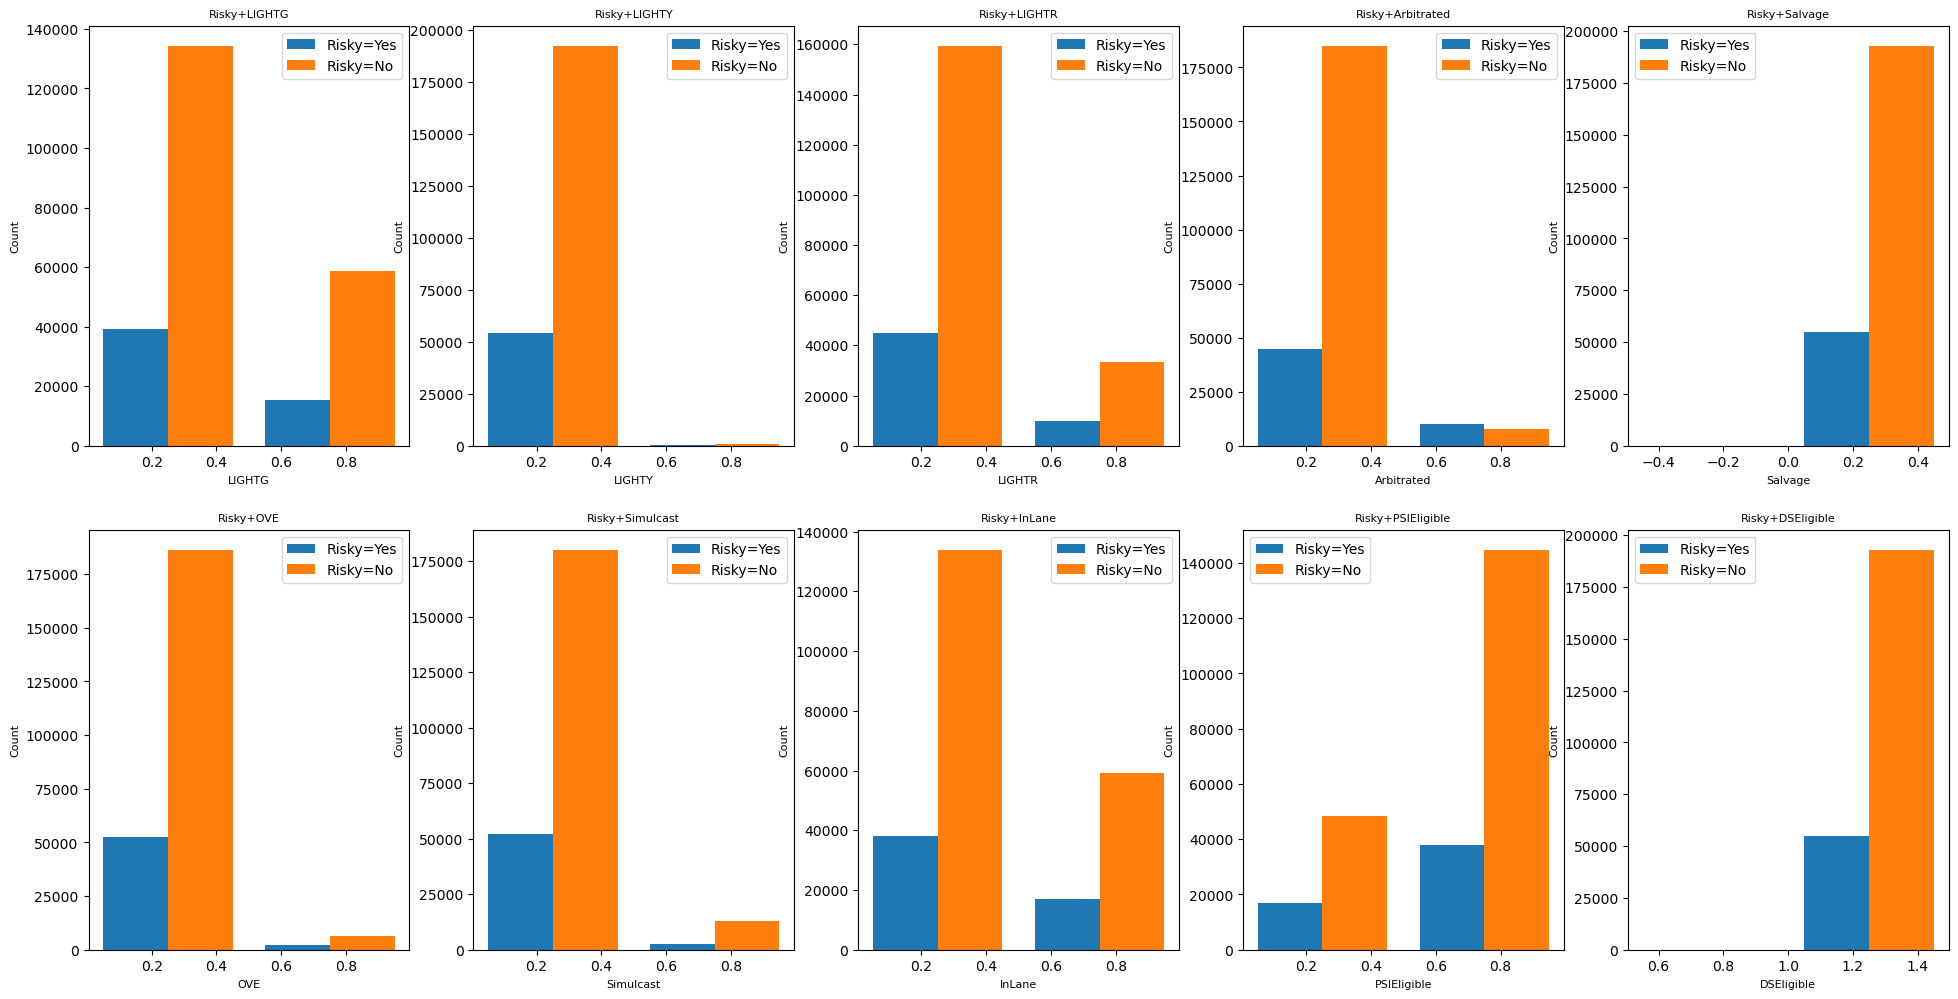

In [52]:
columns = ['LIGHTG', 'LIGHTY', 'LIGHTR', 'Arbitrated', 'Salvage', 'OVE', 'Simulcast', 'InLane','PSIEligible','DSEligible']
index = 0
fig, axs = plt.subplots(2, 5,figsize=(24, 12))
fontsize = 8

for ax in axs.flat:
    column = columns[index]
    df = df_risky.dropna(subset=[column])        
    ax.hist([df[df['risky_yes']==1][column],df[df['risky_no']==1][column]],bins=2,label=['Risky=Yes','Risky=No'])
    ax.set_xlabel(column, fontsize=fontsize)
    ax.set_ylabel('Count', fontsize=fontsize)
    ax.set_title('Risky+'+column, fontsize=fontsize)
    ax.legend()
    index = index + 1

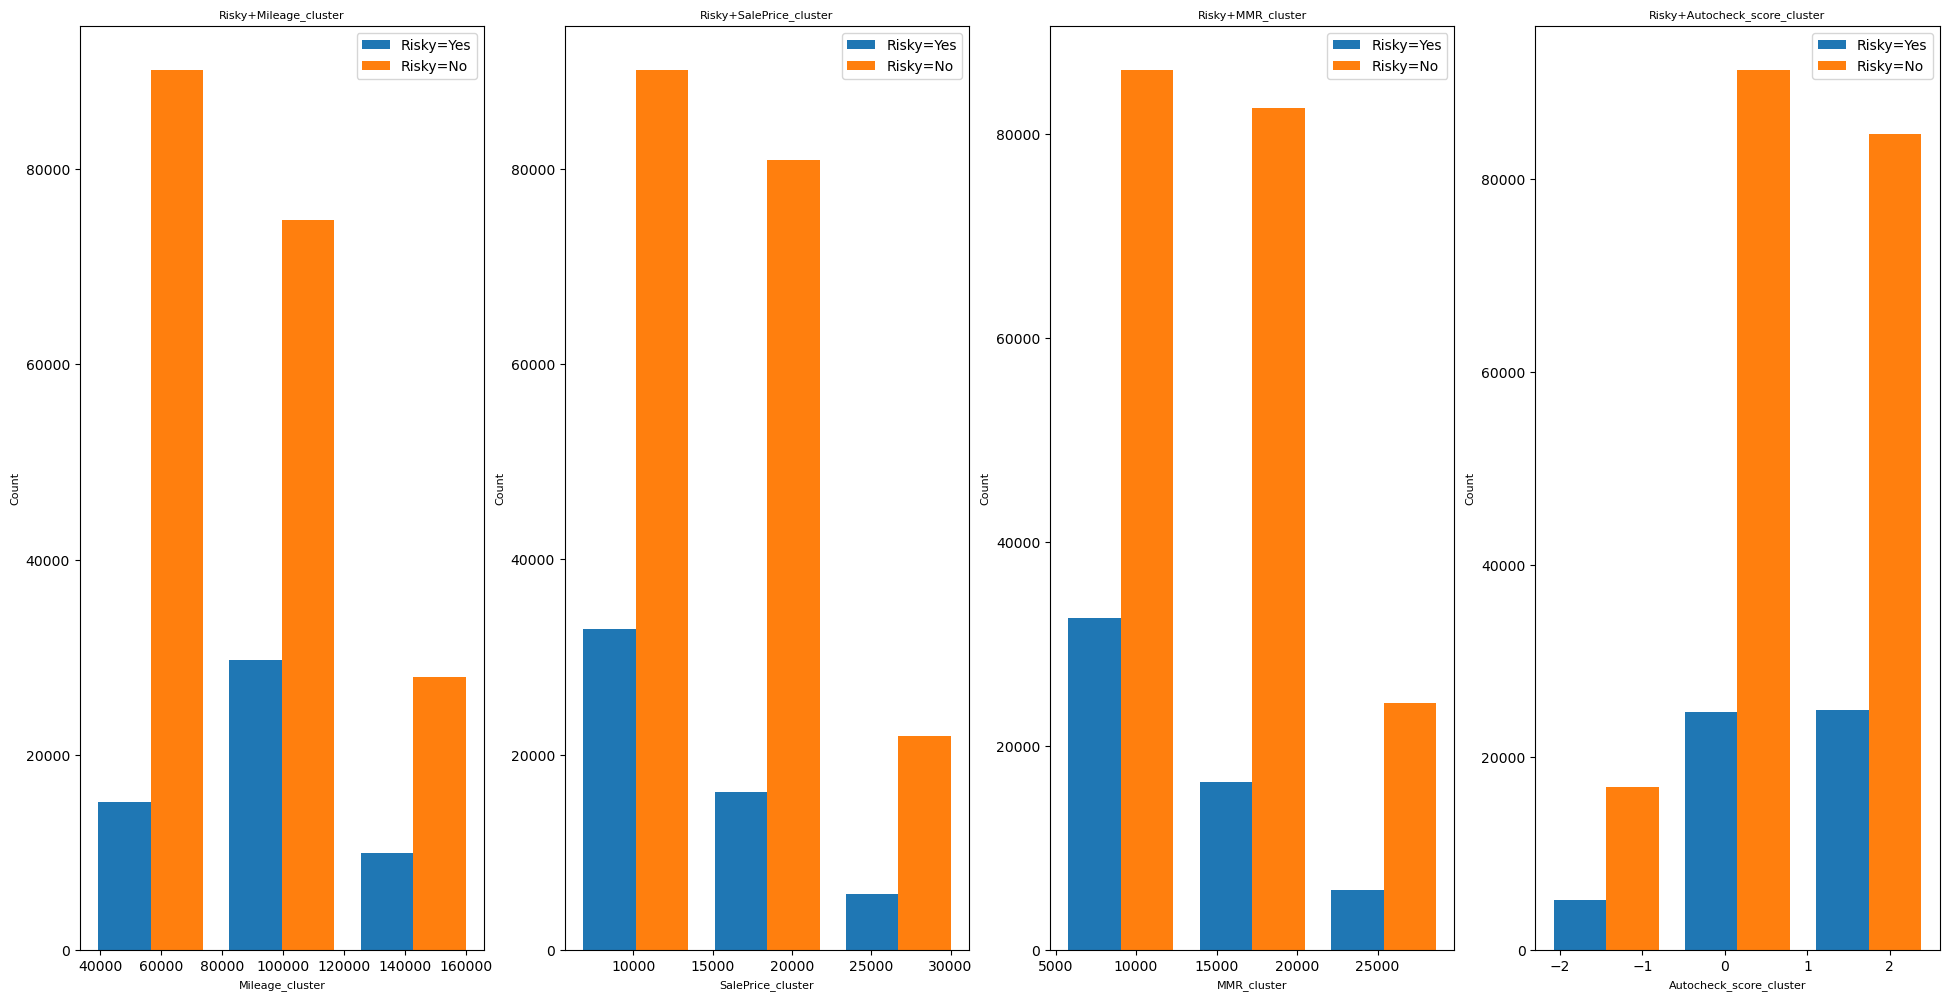

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

columns = ['Mileage', 'SalePrice', 'MMR','Autocheck_score']
index = 0
fig, axs = plt.subplots(1,4,figsize=(24, 12))
fontsize = 8

for ax in axs.flat:
    column = columns[index]
    df = df_risky.dropna(subset=[column])
    Xt = np.array(df[column],dtype=np.float32).reshape(-1,1)

    kmeans = KMeans(n_clusters=3)
    kmeans.fit(Xt)
    df[column+'_cluster'] = kmeans.predict(Xt)
    centers = kmeans.cluster_centers_
    df[column+'_cluster_center'] = df[column+'_cluster'].apply(lambda s: centers[s][0])
    ax.hist([df[df['risky_yes']==1][column+'_cluster_center'],df[df['risky_no']==1][column+'_cluster_center']],bins=3,label=['Risky=Yes','Risky=No'])
    ax.set_xlabel(column+'_cluster', fontsize=fontsize)
    ax.set_ylabel('Count', fontsize=fontsize)
    ax.set_title('Risky+'+column+'_cluster', fontsize=fontsize)
    ax.legend()
    index = index + 1

['Mileage', 'SalePrice'] [[163388.16     4848.7026]
 [ 34869.594   18711.43  ]
 [ 93878.62     9164.934 ]]
['Mileage', 'MMR'] [[ 93904.516    8650.57  ]
 [163554.17     4516.4473]
 [ 34834.652   17798.898 ]]
['SalePrice', 'MMR'] [[15648.0625 15168.468 ]
 [30639.445  30117.852 ]
 [ 6224.3506  5403.2207]]


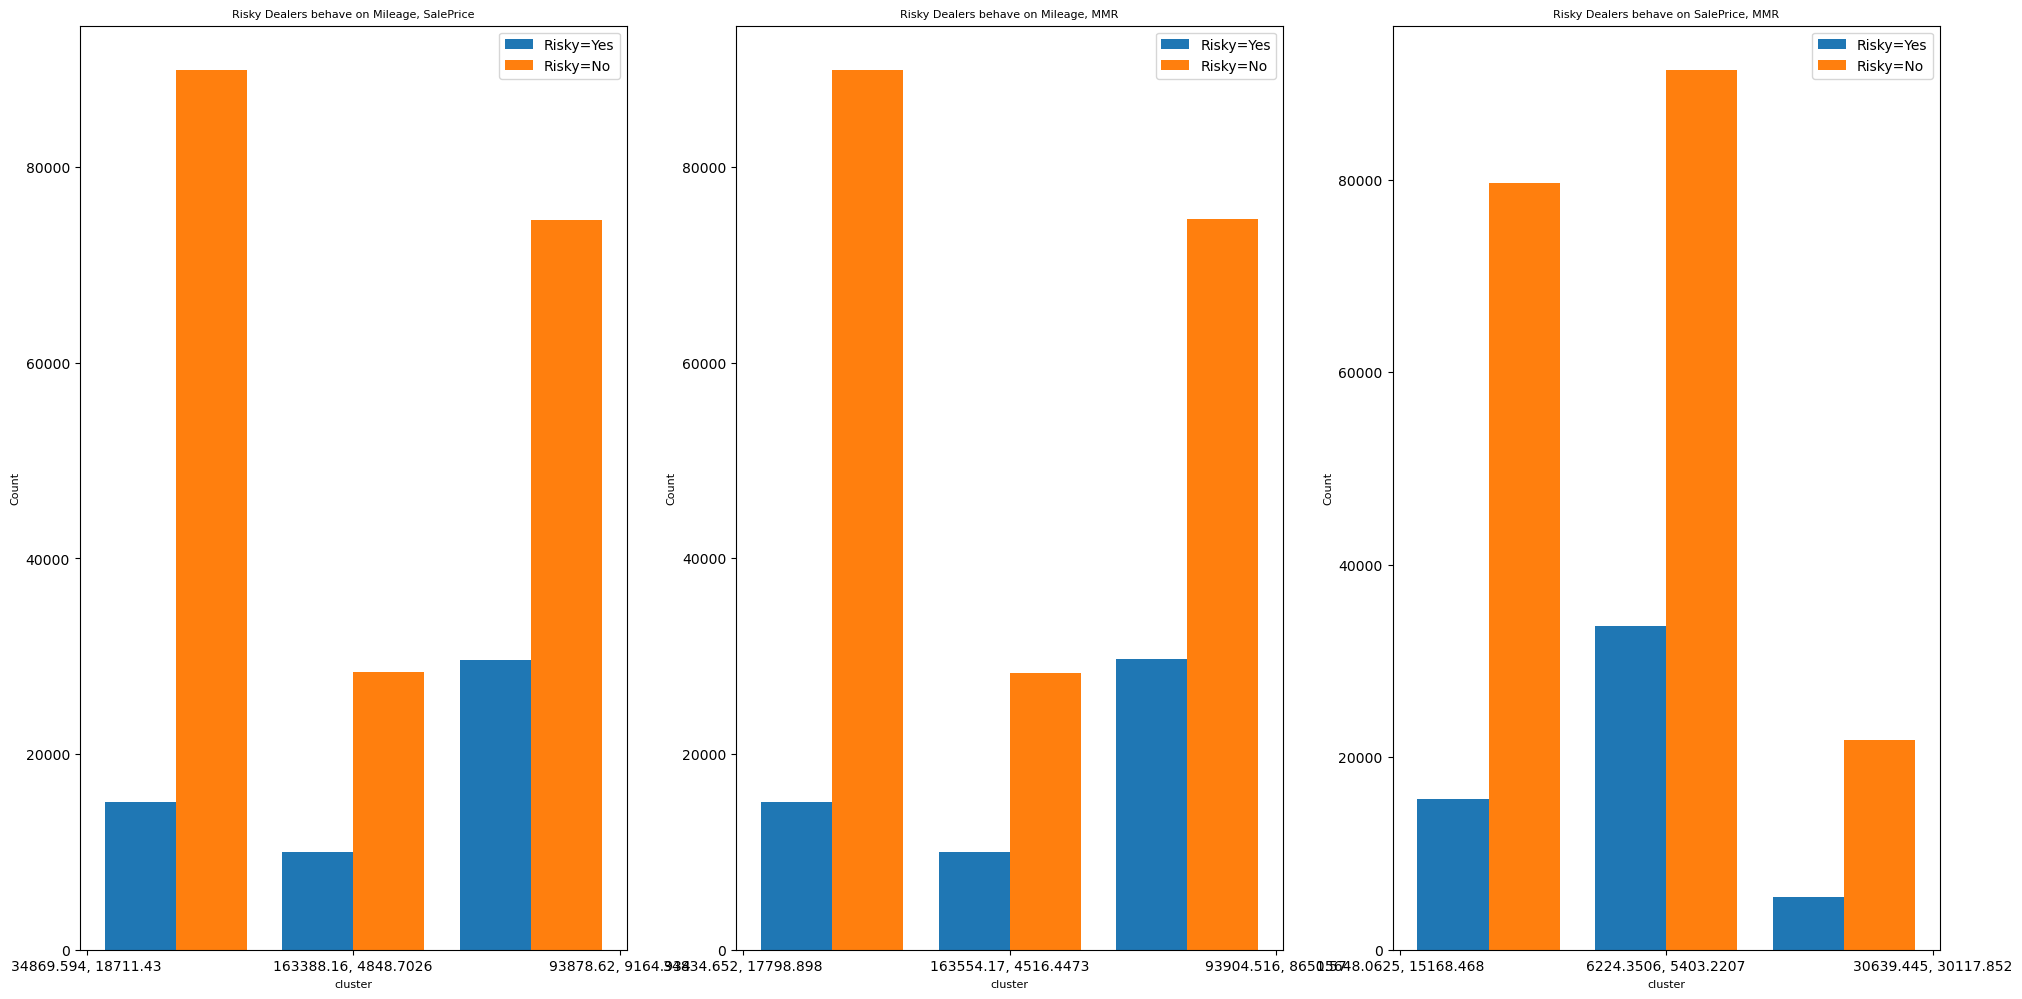

In [54]:
columns = [['Mileage', 'SalePrice'],['Mileage', 'MMR'],[ 'SalePrice', 'MMR']]
index = 0
fig, axs = plt.subplots(1,3,figsize=(24, 12))
fontsize = 8

for ax in axs.flat:
    column = columns[index]
    df = df_risky.dropna(subset=column)
    Xt = np.array(df[column],dtype=np.float32).reshape(-1,len(column))

    kmeans = KMeans(n_clusters=3)
    kmeans.fit(Xt)
    df['cluster'] = kmeans.predict(Xt)
    centers = kmeans.cluster_centers_
    print(column, centers)

    df['cluster_center'] = df['cluster'].apply(lambda s: ', '.join([str(c) for c in centers[s]]))
    ax.hist([df[df['risky_yes']==1]['cluster_center'],df[df['risky_no']==1]['cluster_center']],bins=3,label=['Risky=Yes','Risky=No'])
    ax.set_xlabel('cluster', fontsize=fontsize)
    ax.set_ylabel('Count', fontsize=fontsize)
    ax.set_title('Risky Dealers behave on '+ ', '.join(column), fontsize=fontsize)
    ax.legend()
    index = index + 1